In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import RELACS as rel
import os
sns.set_style("white")
sns.set_context("paper")
%matplotlib inline
%load_ext rpy2.ipython

/package/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/package/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


### IDENTIFY ENRICHED REGIONS AND BACKGROUND SIGNAL USING PLOTFINGERPRINT 

In [112]:
%%bash

module load deeptools

SNAKEPIPE_OUTDIR="/data/manke/group/ferrari/PhD_project/reference_datasets/autoRELACS_dataset/output_snakePipes_Drosophila_merged"


plotFingerprint -b $SNAKEPIPE_OUTDIR/filtered_bam/*H3K4me3*.bam -o ../figures/fingerprint_H3K4me3.png \
--outRawCounts ../intermediate_files/fingerprint_H3K4me3.counts -e \
--outQualityMetrics ../intermediate_files/fingerprint_H3K4me3.metrics -bs 8000 -n 100000 \
-p 20

plotFingerprint -b $SNAKEPIPE_OUTDIR/filtered_bam/*H3K27ac*.bam -o ../figures/fingerprint_H3K27ac.png \
--outRawCounts ../intermediate_files/fingerprint_H3K27ac.counts -e \
--outQualityMetrics ../intermediate_files/fingerprint_H3K27ac.metrics -bs 8000 -n 100000 \
-p 20

plotFingerprint -b $SNAKEPIPE_OUTDIR/filtered_bam/*H3K27me3*.bam -o ../figures/fingerprint_H3K27me3.png \
--outRawCounts ../intermediate_files/fingerprint_H3K27me3.counts -e \
--outQualityMetrics ../intermediate_files/fingerprint_H3K27me3.metrics -bs 8000 -n 100000 \
-p 20


50 bins had coverage over the maximum value of 10000000 during synthetic JSD computation
101 bins had coverage over the maximum value of 10000000 during synthetic JSD computation
150 bins had coverage over the maximum value of 10000000 during synthetic JSD computation


In [1]:
def getElbows(metricsFile, sample):
    
    ''' This function takes as input the metrics file output from plotFingerprint
    and a sample name, and retrieves the elbow point from that sample '''
    
    sample = os.path.basename(sample)
    metrics_df = pd.read_csv(metricsFile, sep="\t", comment="#",index_col=0)
    metrics_df.index = [str(os.path.basename(str(idx))) for idx in metrics_df.index]
    return metrics_df["Elbow Point"].loc[sample]

def RLE_NormFactors(counts, metricsFile):
    
    ''' This function that takes as input a count matrix and a plotFingerprint metrics file computed 
    for the same samples, and it returns RLE scaling factors computed on the enriched regions. 
    this normalization inverts the approach of Diaz et al 2010, and performs RLE normalization 
    on the enriched fraction of the genome '''
    
    sorted_dic = dict()
    
    c = pd.read_csv(counts, sep="\t", comment='#')
    c.columns = [str(os.path.basename(str(idx).split("'")[1])) for idx in list(c)]
    
    for sample in list(c):
        sample = os.path.basename(sample)
        elbow = getElbows(metricsFile,sample)
        
        sorted_dic[sample] = [c[sample].sort_values(ascending=True)]
        
        TotSum = sorted_dic[sample][0].sum()
        sorted_dic[sample].append(sorted_dic[sample][0].cumsum()) 
        
        sorted_dic[sample][1] = sorted_dic[sample][1] / TotSum
        
        X = np.array(range(sorted_dic[sample][0].shape[0]+1)[1:]) / sorted_dic[sample][0].shape[0]
        plt.plot(X, sorted_dic[sample][1])
        X_ = X > elbow
        
        idx = list(X_).index(True)
        thr = sorted_dic[sample][1].values[idx]
        plt.axvline(elbow)
        plt.axhline(thr)
        
        sorted_dic[sample].append(sorted_dic[sample][1].mask(sorted_dic[sample][1] < thr).dropna().index)
    
    common_loci = set.union(*[set(sorted_dic[sample][2]) for sample in sorted_dic])
    
    c = c.loc[common_loci]
    
    return 1/rel.RLE(c)[0], sorted_dic, common_loci

### COMPUTE RLE SCALING FACTORS ON THE ENRICHED FRACTION OF THE GENOME FOR EACH MARK

Biomek_H3K4me3.filtered.bam    1.076008
manual_H3K4me3.filtered.bam    0.929361
dtype: float64

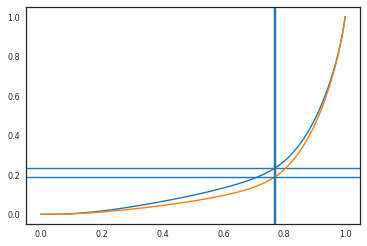

In [4]:
sf, data, loci_norm = RLE_NormFactors("../intermediate_files/fingerprint_H3K4me3.counts","../intermediate_files/fingerprint_H3K4me3.metrics")
sf

In [377]:
# sns.distplot(np.log(data["Biomek_H3K4me3.filtered.bam"][0]+1))
# sns.distplot(np.log(data["manual_H3K4me3.filtered.bam"][0]+1))
# sns.distplot(np.log(data["Biomek_H3K4me3.filtered.bam"][0].loc[loci_norm]*sf[0]))
# sns.distplot(np.log(data["manual_H3K4me3.filtered.bam"][0].loc[loci_norm]*sf[1]))
# plt.figure()
# sns.distplot(np.log((data["Biomek_H3K4me3.filtered.bam"][0]+1)*sf[0]))
# sns.distplot(np.log((data["manual_H3K4me3.filtered.bam"][0]+1)*sf[1]))

Biomek_H3K27ac.filtered.bam    1.497974
manual_H3K27ac.filtered.bam    0.667568
dtype: float64

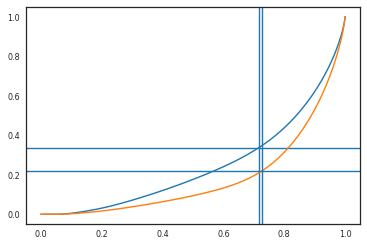

In [5]:
sf, data, loci_norm = RLE_NormFactors("../intermediate_files/fingerprint_H3K27ac.counts","../intermediate_files/fingerprint_H3K27ac.metrics")
sf

In [379]:
# sns.distplot(np.log(data["Biomek_H3K27ac.filtered.bam"][0]+1))
# sns.distplot(np.log(data["manual_H3K27ac.filtered.bam"][0]+1))
# sns.distplot(np.log(data["Biomek_H3K27ac.filtered.bam"][0].loc[loci_norm]*sf[0]))
# sns.distplot(np.log(data["manual_H3K27ac.filtered.bam"][0].loc[loci_norm]*sf[1]))
# plt.figure()
# sns.distplot(np.log((data["Biomek_H3K27ac.filtered.bam"][0]+1)*sf[0]))
# sns.distplot(np.log((data["manual_H3K27ac.filtered.bam"][0]+1)*sf[1]))

Biomek_H3K27me3.filtered.bam    1.038115
manual_H3K27me3.filtered.bam    0.963284
dtype: float64

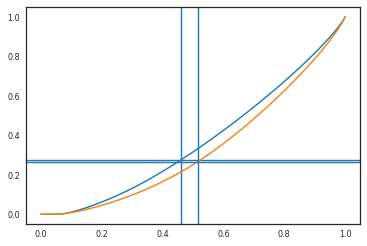

In [380]:
sf, data, loci_norm = RLE_NormFactors("../intermediate_files/fingerprint_H3K27me3.counts","../intermediate_files/fingerprint_H3K27me3.metrics")
sf

In [330]:
# sns.distplot(np.log(data["Biomek_H3K27me3.filtered.bam"][0]+1))
# sns.distplot(np.log(data["manual_H3K27me3.filtered.bam"][0]+1))
# sns.distplot(np.log(data["Biomek_H3K27me3.filtered.bam"][0].loc[loci_norm]*sf[0]))
# sns.distplot(np.log(data["manual_H3K27me3.filtered.bam"][0].loc[loci_norm]*sf[1]))
# plt.figure()
# sns.distplot(np.log((data["Biomek_H3K27me3.filtered.bam"][0]+1)*sf[0]))
# sns.distplot(np.log((data["manual_H3K27me3.filtered.bam"][0]+1)*sf[1]))

### CREATE RLE SCALED COVERAGE TRACKS AND PLOT METAPROFILE ON THE MERGED PEAK SET FOR EACH MARK

# H3K4me3

In [362]:
%%bash

module load deeptools

SNAKEPIPE_OUTDIR="/data/manke/group/ferrari/PhD_project/reference_datasets/autoRELACS_dataset/output_snakePipes_Drosophila_merged"

bamCoverage -b $SNAKEPIPE_OUTDIR/filtered_bam/Biomek_H3K4me3.filtered.bam \
-o ../intermediate_files/Biomek_H3K4me3.filtered.RLEscaled.bw \
--scaleFactor 0.01076008 -p 20 -e 

bamCoverage -b $SNAKEPIPE_OUTDIR/filtered_bam/manual_H3K4me3.filtered.bam \
-o ../intermediate_files/manual_H3K4me3.filtered.RLEscaled.bw \
--scaleFactor 0.00929361 -p 20 -e 

bamFilesList: ['/data/manke/group/ferrari/PhD_project/reference_datasets/autoRELACS_dataset/output_snakePipes_Drosophila_merged/filtered_bam/Biomek_H3K4me3.filtered.bam']
binLength: 50
numberOfSamples: None
blackListFileName: None
skipZeroOverZero: False
bed_and_bin: False
defaultFragmentLength: 233
numberOfProcessors: 20
verbose: False
region: None
bedFile: None
minMappingQuality: None
ignoreDuplicates: False
chrsToSkip: []
stepSize: 50
center_read: False
samFlag_include: None
samFlag_exclude: None
minFragmentLength: 0
maxFragmentLength: 0
zerosToNans: False
smoothLength: None
save_data: False
out_file_for_raw_data: None
maxPairedFragmentLength: 932
bamFilesList: ['/data/manke/group/ferrari/PhD_project/reference_datasets/autoRELACS_dataset/output_snakePipes_Drosophila_merged/filtered_bam/manual_H3K4me3.filtered.bam']
binLength: 50
numberOfSamples: None
blackListFileName: None
skipZeroOverZero: False
bed_and_bin: False
defaultFragmentLength: 235
numberOfProcessors: 20
verbose: False
re

In [363]:
%%bash

module load deeptools

computeMatrix reference-point -R ../intermediate_files/Merged_Peaks_H3K4me3.bed \
-S ../intermediate_files/Biomek_H3K4me3.filtered.RLEscaled.bw \
../intermediate_files/manual_H3K4me3.filtered.RLEscaled.bw \
-o ../intermediate_files/H3K4me3_merged_plotProfile.mat.gz \
--referencePoint center --missingDataAsZero -p 20 -b 2000 -a 2000

In [364]:
%%bash

module load deeptools

plotProfile -m ../intermediate_files/H3K4me3_merged_plotProfile.mat.gz \
-o ../figures/H3K4me3_merged_plotProfile.pdf --perGroup --averageType median \
--plotHeight 7 --plotWidth 8 --colors darkred coral

# H3K27ac

In [365]:
%%bash

module load deeptools

SNAKEPIPE_OUTDIR="/data/manke/group/ferrari/PhD_project/reference_datasets/autoRELACS_dataset/output_snakePipes_Drosophila_merged"

bamCoverage -b $SNAKEPIPE_OUTDIR/filtered_bam/Biomek_H3K27ac.filtered.bam \
-o ../intermediate_files/Biomek_H3K27ac.filtered.RLEscaled.bw \
--scaleFactor 0.01497974 -p 20 -e 

bamCoverage -b $SNAKEPIPE_OUTDIR/filtered_bam/manual_H3K27ac.filtered.bam \
-o ../intermediate_files/manual_H3K27ac.filtered.RLEscaled.bw \
--scaleFactor 0.00667568 -p 20 -e 

bamFilesList: ['/data/manke/group/ferrari/PhD_project/reference_datasets/autoRELACS_dataset/output_snakePipes_Drosophila_merged/filtered_bam/Biomek_H3K27ac.filtered.bam']
binLength: 50
numberOfSamples: None
blackListFileName: None
skipZeroOverZero: False
bed_and_bin: False
defaultFragmentLength: 213
numberOfProcessors: 20
verbose: False
region: None
bedFile: None
minMappingQuality: None
ignoreDuplicates: False
chrsToSkip: []
stepSize: 50
center_read: False
samFlag_include: None
samFlag_exclude: None
minFragmentLength: 0
maxFragmentLength: 0
zerosToNans: False
smoothLength: None
save_data: False
out_file_for_raw_data: None
maxPairedFragmentLength: 852
bamFilesList: ['/data/manke/group/ferrari/PhD_project/reference_datasets/autoRELACS_dataset/output_snakePipes_Drosophila_merged/filtered_bam/manual_H3K27ac.filtered.bam']
binLength: 50
numberOfSamples: None
blackListFileName: None
skipZeroOverZero: False
bed_and_bin: False
defaultFragmentLength: 239
numberOfProcessors: 20
verbose: False
re

In [366]:
%%bash

module load deeptools

computeMatrix reference-point -R ../intermediate_files/Merged_Peaks_H3K27ac.bed \
-S ../intermediate_files/Biomek_H3K27ac.filtered.RLEscaled.bw \
../intermediate_files/manual_H3K27ac.filtered.RLEscaled.bw \
-o ../intermediate_files/H3K27ac_merged_plotProfile.mat.gz \
--referencePoint center --missingDataAsZero -p 20 -b 2000 -a 2000

In [367]:
%%bash

module load deeptools

plotProfile -m ../intermediate_files/H3K27ac_merged_plotProfile.mat.gz \
-o ../figures/H3K27ac_merged_plotProfile.pdf --perGroup --averageType median \
--plotHeight 7 --plotWidth 8 --colors darkgreen limegreen

# H3K27me3

In [368]:
%%bash

module load deeptools

SNAKEPIPE_OUTDIR="/data/manke/group/ferrari/PhD_project/reference_datasets/autoRELACS_dataset/output_snakePipes_Drosophila_merged"

bamCoverage -b $SNAKEPIPE_OUTDIR/filtered_bam/Biomek_H3K27me3.filtered.bam \
-o ../intermediate_files/Biomek_H3K27me3.filtered.RLEscaled.bw \
--scaleFactor 0.01038115 -p 20 -e 

bamCoverage -b $SNAKEPIPE_OUTDIR/filtered_bam/manual_H3K27me3.filtered.bam \
-o ../intermediate_files/manual_H3K27me3.filtered.RLEscaled.bw \
--scaleFactor 0.00963284 -p 20 -e 

bamFilesList: ['/data/manke/group/ferrari/PhD_project/reference_datasets/autoRELACS_dataset/output_snakePipes_Drosophila_merged/filtered_bam/Biomek_H3K27me3.filtered.bam']
binLength: 50
numberOfSamples: None
blackListFileName: None
skipZeroOverZero: False
bed_and_bin: False
defaultFragmentLength: 253
numberOfProcessors: 20
verbose: False
region: None
bedFile: None
minMappingQuality: None
ignoreDuplicates: False
chrsToSkip: []
stepSize: 50
center_read: False
samFlag_include: None
samFlag_exclude: None
minFragmentLength: 0
maxFragmentLength: 0
zerosToNans: False
smoothLength: None
save_data: False
out_file_for_raw_data: None
maxPairedFragmentLength: 1012
bamFilesList: ['/data/manke/group/ferrari/PhD_project/reference_datasets/autoRELACS_dataset/output_snakePipes_Drosophila_merged/filtered_bam/manual_H3K27me3.filtered.bam']
binLength: 50
numberOfSamples: None
blackListFileName: None
skipZeroOverZero: False
bed_and_bin: False
defaultFragmentLength: 245
numberOfProcessors: 20
verbose: False

In [369]:
%%bash

module load deeptools

computeMatrix scale-regions -R ../intermediate_files/Merged_Peaks_H3K27me3.bed \
-S ../intermediate_files/Biomek_H3K27me3.filtered.RLEscaled.bw \
../intermediate_files/manual_H3K27me3.filtered.RLEscaled.bw \
-o ../intermediate_files/H3K27me3_merged_plotProfile.mat.gz \
--missingDataAsZero -p 20 -b 400 -a 400

In [370]:
%%bash

module load deeptools

plotProfile -m ../intermediate_files/H3K27me3_merged_plotProfile.mat.gz \
-o ../figures/H3K27me3_merged_plotProfile.pdf --perGroup --averageType median \
--plotHeight 7 --plotWidth 8 --colors black dimgray